In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# Get the current directory of the notebook
# and go up one level to the project root ('KINETICCONSTANTS_TEST')
project_root = os.path.abspath("..")

# Add the project root to the system path if it's not there already
if project_root not in sys.path:
    sys.path.append(project_root)

In [3]:
from torch_geometric.data import Data, Dataset, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, dense_to_sparse
import torch
import torch.nn as nn
import lmdb
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd
from model import SimpleGNN, mlp
import os
from simulation.produce_simulations import SimulatedGraphDataset

In [5]:
ckpt_dir = '../model_checkpoints'  # Directory to load checkpoints
ckpt = 4
num_nodes = 113
num_edges = 350
model = mlp(in_channels=int(num_nodes), out_channel=int(num_edges), hidden_dim=[int(0.5*num_nodes), int(0.3*num_nodes), int(0.2*num_nodes), int(0.1*num_nodes)], hidden_num=4)
model.load_state_dict(torch.load(os.path.join(ckpt_dir, f'mlp_epoch_{ckpt}.pth')))
model.eval()

MLP hidden dimensions set to: [56, 33, 22, 11]


mlp(
  (mlp): Sequential(
    (0): Linear(in_features=113, out_features=56, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=56, out_features=33, bias=True)
    (4): PReLU(num_parameters=1)
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=33, out_features=22, bias=True)
    (7): PReLU(num_parameters=1)
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=22, out_features=11, bias=True)
    (10): PReLU(num_parameters=1)
    (11): Linear(in_features=11, out_features=350, bias=True)
  )
)

In [6]:
db_path = '../simulation/simulated_graph_dataset'
dataset = SimulatedGraphDataset(root=db_path)
torch.manual_seed(42)
dataset = dataset.shuffle()  # Shuffle the dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = dataset[:train_size], dataset[train_size:]
small_test_dataset = test_dataset[:100]
small_train_dataset = train_dataset[:100]

batch_size = 32  # Adjust batch size as needed
test_loader = DataLoader(small_test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
train_loader = DataLoader(small_train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [9]:
for batch in test_loader:
    print(batch.batch_size)

32
32
32
4


In [12]:
num_edges = 350
ks_pred = {f'k_{idx}': np.array([]) for idx in range(num_edges)}
ks_true = {f'k_{idx}': np.array([]) for idx in range(num_edges)}

with torch.no_grad():
    for i in range(10):
        for batch in tqdm(train_loader, desc="Evaluating"):
            data = batch.to('cpu')
            pred = model(data.x[:, i].clone().view(batch.batch_size, -1))
            targets = torch.as_tensor(np.array(batch.parameters['kinetic_constants']), dtype=torch.float32)
            targets = targets[targets != 0].view_as(pred)
            
            for idx in range(num_edges):
                ks_pred[f'k_{idx}'] = np.append(ks_pred[f'k_{idx}'], np.array(pred[:, idx]))
                ks_true[f'k_{idx}'] = np.append(ks_true[f'k_{idx}'], np.array(targets[:, idx]))

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]C:\Users\cirob\AppData\Local\Temp\ipykernel_8596\2559394193.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  ks_pred[f'k_{idx}'] = np.append(ks_pred[f'k_{idx}'], np.array(pred[:, idx]))
C:\Users\cirob\AppData\Local\Temp\ipykernel_8596\2559394193.py:15: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  ks_true[f'k_{idx}'] = np.append(ks_true[f'k_{idx}'], np.array(targets[:, idx]))
Evaluating: 100%|██████████| 4/4 [00:00<00:00,

In [11]:
adj_matrix_df = pd.read_csv('../simulation/adjacency_matrix.csv', index_col=0)
all_lipids = adj_matrix_df.index.tolist()
adj_matrix = np.array(adj_matrix_df)
num_edges = np.sum(adj_matrix, dtype=int)
correlation_matrix_partial = pd.read_csv('../simulation/correlation_matrix.csv', index_col=0)
correlation_matrix = pd.DataFrame(np.eye(len(all_lipids)), index=all_lipids, columns=all_lipids)
L = np.linalg.cholesky(correlation_matrix.values)

ks_pred = {f'k_{idx}': np.array([]) for idx in range(num_edges)}
ks_true = {f'k_{idx}': np.array([]) for idx in range(num_edges)}

with torch.no_grad():
    for batch in tqdm(train_loader, desc="Evaluating"):
        data = batch.to('cpu')
        out_node, out_edge = model(data.x, data.edge_index , data.batch)
        k_prod, k_deg, sigma_conc, dropout = out_node.split([1, 1, 1, 1], dim=-1)
        k, sigma_k = out_edge.split([1, 1], dim=-1)
        row, col = data.edge_index
        row = row[:num_edges]
        col = col[:num_edges]
        
        for idx in range(num_edges):
            ks_pred[f'k_{idx}'] = np.append(ks_pred[f'k_{idx}'], np.array(k[idx::num_edges]))
            ks_true[f'k_{idx}'] = np.append(ks_true[f'k_{idx}'], np.array(data.parameters['kinetic_constants'])[:, row[idx], col[idx]])

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]


TypeError: mlp.forward() takes 2 positional arguments but 4 were given

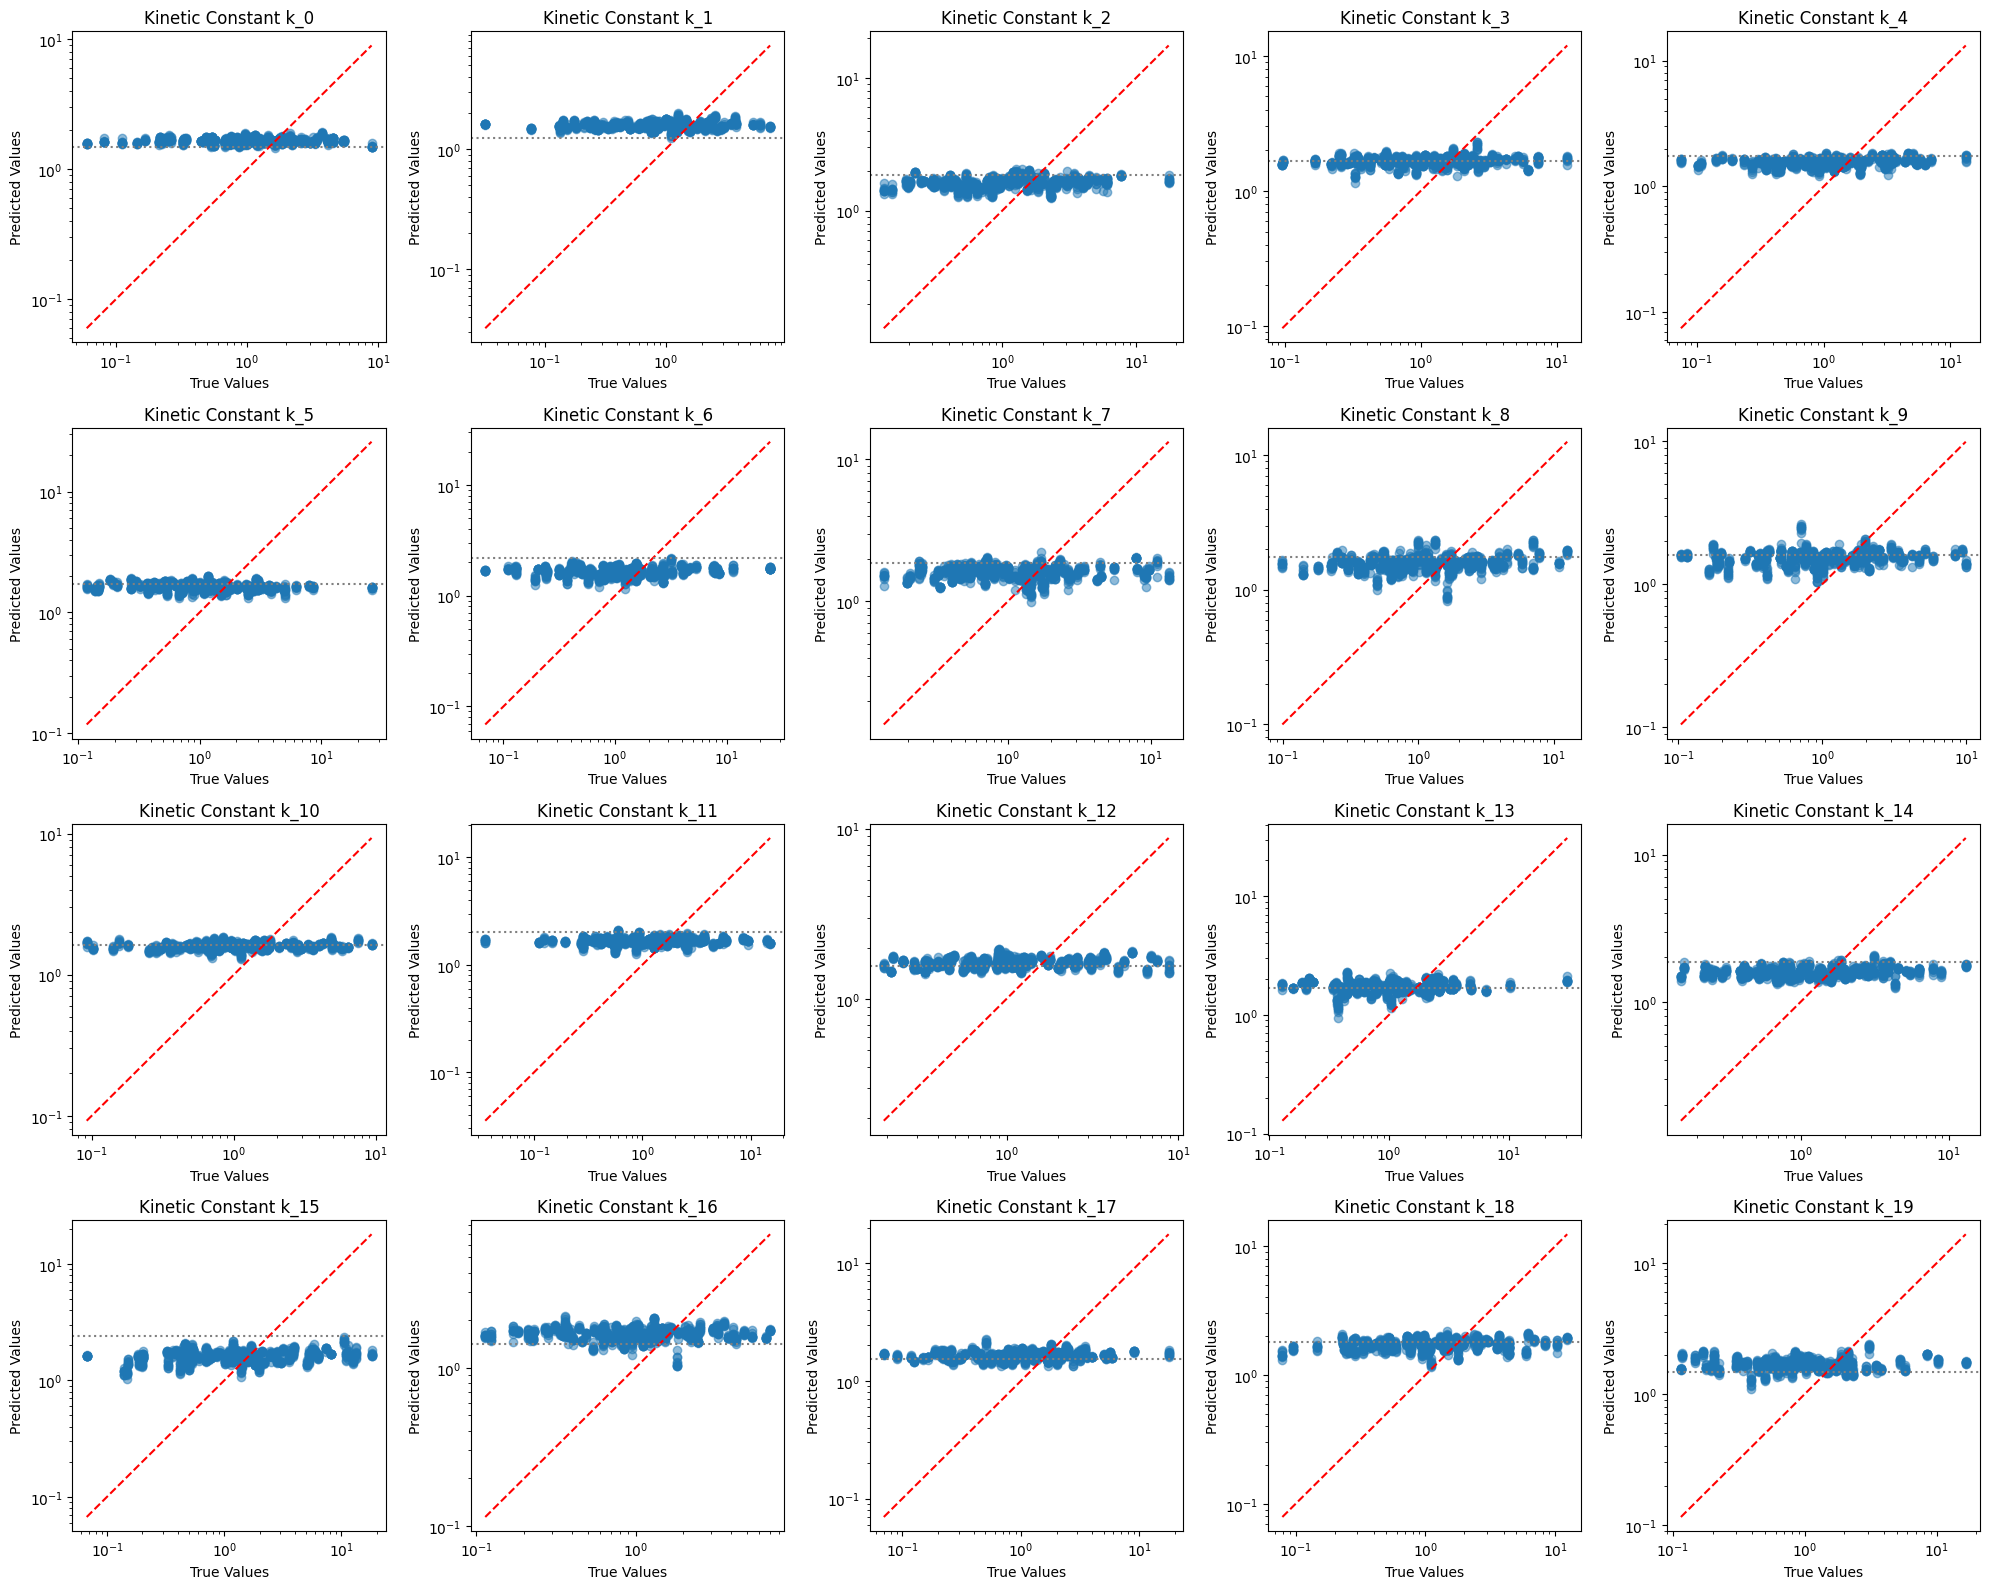

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(20, 16), tight_layout=True, subplot_kw={'xscale': 'log', 'yscale': 'log'})
for idx in range(20):
    row = idx // 5
    col = idx % 5
    axs[row, col].scatter(ks_true[f'k_{idx}'], ks_pred[f'k_{idx}'], alpha=0.5)
    axs[row, col].plot([min(ks_true[f'k_{idx}']), max(ks_true[f'k_{idx}'])],
                       [min(ks_true[f'k_{idx}']), max(ks_true[f'k_{idx}'])], 'r--')
    axs[row, col].axhline(y=np.mean(ks_true[f'k_{idx}']), color='gray', linestyle='dotted')
    axs[row, col].set_title(f'Kinetic Constant k_{idx}')
    axs[row, col].set_xlabel('True Values')
    axs[row, col].set_ylabel('Predicted Values')
    axs